# Питер и волк: Введение в обучение с подкреплением

В этом уроке мы научимся применять обучение с подкреплением к задаче поиска пути. Сюжет вдохновлен музыкальной сказкой [«Петя и волк»](https://en.wikipedia.org/wiki/Peter_and_the_Wolf) русского композитора [Сергея Прокофьева](https://en.wikipedia.org/wiki/Sergei_Prokofiev). Это история о юном пионере Пете, который смело выходит из дома на лесную поляну, чтобы поймать волка. Мы будем обучать алгоритмы машинного обучения, которые помогут Пете исследовать окружающую местность и построить оптимальную карту навигации.

Сначала импортируем несколько полезных библиотек:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## Обзор обучения с подкреплением

**Обучение с подкреплением** (Reinforcement Learning, RL) — это метод обучения, который позволяет нам изучить оптимальное поведение **агента** в некоторой **среде** путем проведения множества экспериментов. Агент в этой среде должен иметь какую-то **цель**, определяемую с помощью **функции вознаграждения**.

## Среда

Для простоты давайте представим мир Питера в виде квадратной доски размером `width` x `height`. Каждая клетка на этой доске может быть:
* **землей**, по которой Питер и другие существа могут ходить
* **водой**, по которой, очевидно, ходить нельзя
* **деревом** или **травой** — местом, где можно отдохнуть
* **яблоком**, которое представляет собой что-то, что Питер был бы рад найти, чтобы подкрепиться
* **волком**, который опасен и которого следует избегать

Для работы со средой мы определим класс `Board`. Чтобы не перегружать эту записную книжку, весь код для работы с доской был вынесен в отдельный модуль `rlboard`, который мы сейчас импортируем. Вы можете заглянуть внутрь этого модуля, чтобы узнать больше о внутренней реализации.


In [2]:
from rlboard import *

Давайте теперь создадим случайную доску и посмотрим, как она выглядит:


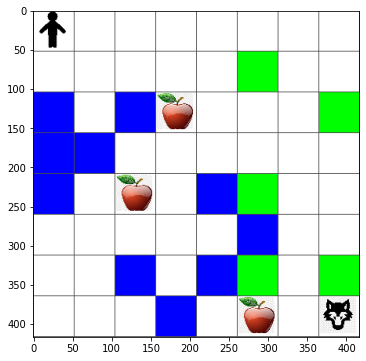

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## Действия и Политика

В нашем примере цель Питера — найти яблоко, избегая волка и других препятствий. Для этого он может просто ходить, пока не найдет яблоко. Таким образом, в любой точке он может выбрать одно из следующих действий: вверх, вниз, влево и вправо. Мы определим эти действия как словарь и сопоставим их с парами соответствующих изменений координат. Например, движение вправо (`R`) будет соответствовать паре `(1,0)`.


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

Стратегия нашего агента (Питера) определяется так называемой **политикой**. Рассмотрим самую простую политику под названием **случайное блуждание**.

## Случайное блуждание

Давайте сначала решим нашу задачу, реализовав стратегию случайного блуждания.


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

Давайте проведем эксперимент случайного блуждания несколько раз и посмотрим среднее количество сделанных шагов:


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## Функция вознаграждения

Чтобы сделать нашу стратегию более умной, нам нужно понять, какие ходы являются "лучше" других.


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## Q-Learning

Создайте Q-таблицу или многомерный массив. Поскольку наша доска имеет размеры `width` x `height`, мы можем представить Q-таблицу в виде numpy массива с формой `width` x `height` x `len(actions)`:


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

Передайте Q-таблицу в функцию построения графика, чтобы визуализировать таблицу на доске:


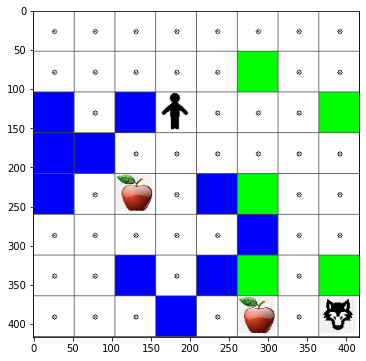

In [9]:
m.plot(Q)

## Суть Q-Learning: Уравнение Беллмана и алгоритм обучения

Напишите псевдокод для нашего алгоритма обучения:

* Инициализируйте Q-таблицу Q одинаковыми значениями для всех состояний и действий
* Установите скорость обучения $\alpha\leftarrow 1$
* Повторяйте симуляцию много раз
   1. Начните с случайной позиции
   1. Повторяйте
        1. Выберите действие $a$ в состоянии $s$
        2. Выполните действие, перейдя в новое состояние $s'$
        3. Если достигнуто условие окончания игры или общий награда слишком мала — завершите симуляцию  
        4. Вычислите награду $r$ в новом состоянии
        5. Обновите Q-функцию согласно уравнению Беллмана: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. Обновите общий награду и уменьшите $\alpha$.

## Эксплуатация vs. Исследование

Лучший подход — это баланс между исследованием и эксплуатацией. По мере того как мы больше узнаем об окружающей среде, мы будем чаще следовать оптимальному маршруту, однако иногда стоит выбирать неизведанный путь.

## Реализация на Python

Теперь мы готовы реализовать алгоритм обучения. Прежде чем это сделать, нам также понадобится функция, которая преобразует произвольные числа в Q-таблице в вектор вероятностей для соответствующих действий:


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

Мы добавляем небольшое значение `eps` к исходному вектору, чтобы избежать деления на 0 в начальном случае, когда все компоненты вектора одинаковы.

Фактический алгоритм обучения, который мы будем запускать в течение 5000 экспериментов, также называемых **эпохами**:


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

После выполнения этого алгоритма Q-таблица должна быть обновлена значениями, которые определяют привлекательность различных действий на каждом шаге. Визуализируйте таблицу здесь:


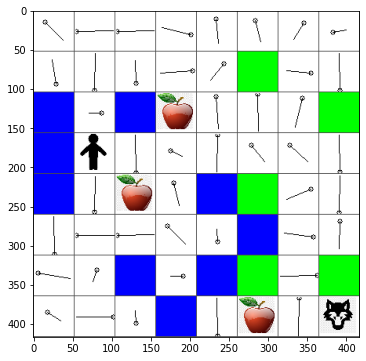

In [12]:
m.plot(Q)

## Проверка политики

Поскольку Q-Table содержит "привлекательность" каждого действия в каждом состоянии, его довольно легко использовать для определения эффективной навигации в нашем мире. В самом простом случае мы можем просто выбрать действие, соответствующее наибольшему значению в Q-Table:


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

Если вы попробуете код выше несколько раз, вы можете заметить, что иногда он просто "зависает", и вам нужно нажать кнопку "СТОП" в ноутбуке, чтобы прервать выполнение.

> **Задача 1:** Измените функцию `walk`, чтобы ограничить максимальную длину пути определенным количеством шагов (например, 100), и наблюдайте, как код выше периодически возвращает это значение.

> **Задача 2:** Измените функцию `walk`, чтобы она не возвращалась в места, где уже была ранее. Это предотвратит зацикливание `walk`, однако агент все равно может оказаться "запертым" в месте, из которого он не сможет выбраться.


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


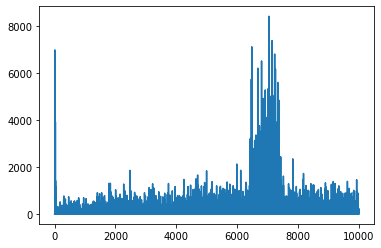

In [15]:
plt.plot(lpath)

Что мы видим здесь, так это то, что сначала средняя длина пути увеличилась. Это, вероятно, связано с тем, что, когда мы ничего не знаем об окружающей среде, мы склонны попадать в плохие состояния, такие как вода или волк. По мере того, как мы узнаем больше и начинаем использовать эти знания, мы можем исследовать окружающую среду дольше, но все еще плохо знаем, где находятся яблоки.

Как только мы узнаем достаточно, агенту становится легче достигать цели, и длина пути начинает уменьшаться. Однако мы все еще открыты для исследования, поэтому часто отклоняемся от оптимального пути и пробуем новые варианты, что делает путь длиннее, чем он мог бы быть.

Также на этом графике мы наблюдаем, что в какой-то момент длина пути резко увеличилась. Это указывает на стохастическую природу процесса и на то, что мы можем в какой-то момент "испортить" коэффициенты Q-таблицы, перезаписав их новыми значениями. Это желательно минимизировать, уменьшая скорость обучения (то есть ближе к концу обучения мы корректируем значения Q-таблицы лишь на небольшую величину).

В целом важно помнить, что успех и качество процесса обучения значительно зависят от параметров, таких как скорость обучения, уменьшение скорости обучения и коэффициент дисконтирования. Эти параметры часто называют **гиперпараметрами**, чтобы отличить их от **параметров**, которые мы оптимизируем во время обучения (например, коэффициенты Q-таблицы). Процесс поиска лучших значений гиперпараметров называется **оптимизацией гиперпараметров**, и он заслуживает отдельного обсуждения.


## Упражнение
#### Более реалистичный мир "Петя и волк"

В нашей ситуации Петя мог передвигаться почти без усталости и голода. В более реалистичном мире ему нужно время от времени садиться и отдыхать, а также питаться. Давайте сделаем наш мир более реалистичным, внедрив следующие правила:

1. При перемещении из одного места в другое Петя теряет **энергию** и набирает **усталость**.
2. Петя может восстановить энергию, съев яблоки.
3. Петя может избавиться от усталости, отдыхая под деревом или на траве (т.е. заходя на клетку с деревом или травой — зеленое поле).
4. Петя должен найти и убить волка.
5. Чтобы убить волка, Петя должен иметь определенный уровень энергии и усталости, иначе он проиграет битву.

Измените функцию вознаграждения в соответствии с правилами игры, запустите алгоритм обучения с подкреплением, чтобы найти лучшую стратегию для победы в игре, и сравните результаты случайного блуждания с вашим алгоритмом по количеству выигранных и проигранных игр.

> **Note**: Возможно, вам потребуется настроить гиперпараметры, чтобы всё заработало, особенно количество эпох. Поскольку успех в игре (битва с волком) — это редкое событие, можно ожидать значительно более длительного времени обучения.



---

**Отказ от ответственности**:  
Этот документ был переведен с помощью сервиса автоматического перевода [Co-op Translator](https://github.com/Azure/co-op-translator). Несмотря на наши усилия обеспечить точность, автоматические переводы могут содержать ошибки или неточности. Оригинальный документ на его родном языке следует считать авторитетным источником. Для получения критически важной информации рекомендуется профессиональный перевод человеком. Мы не несем ответственности за любые недоразумения или неправильные интерпретации, возникшие в результате использования данного перевода.
